In [1]:
from u_cmab import Train, qini
import pandas as pd
import torch.nn as nn
import torch

# Data

In [2]:
data = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
data["segment"] = data["segment"].astype("category")
data["history_segment"] = data["history_segment"].astype("category")
data["zip_code"] = data["zip_code"].astype("category")
data["channel"] = data["channel"].astype("category")

data_size = data.shape[0]

In [3]:
def parse_data_hillstrom(data):
    context = data[["recency", "history_segment", "history", "mens", "womens", "zip_code", "newbie", "channel"]].copy()
    treatment = data["segment"]
    reward = data["visit"]

    one_hot_hs = pd.get_dummies(context["history_segment"], prefix="hs")
    one_hot_zc = pd.get_dummies(context["zip_code"], prefix="zc")
    one_hot_c = pd.get_dummies(context["channel"], prefix="c")

    context = pd.concat([context[["recency", "history", "mens", "womens", "newbie"]], one_hot_hs, one_hot_zc, one_hot_c], axis=1)

    return (context.values, treatment.values, reward.values)

# Experiment
experiment runs `10` times: trains ANN for 400 epochs and 2 URFs each time, this takes considerable time on a PC.

In [5]:
hidden = 35
context_n = 18
treatment_n = 3

forests_m = []
forests_w = []
nets_m = []
nets_w = []
treats_m = []
treats_w = []
resps_m = []
resps_w = []

In [6]:
runs = 10
for i in range(runs):
    t = Train(data, parse_data_hillstrom)
    
    # 2 RF's
    u_w = t.rf(segment="w")
    u_m = t.rf(segment="m")
    
    # 1 NET
    net = nn.Sequential(
        nn.Linear(context_n, 36),
        nn.ReLU(),
        nn.Linear(36, 36),
        nn.ReLU(),
        nn.Linear(36, 36),
        nn.ReLU(),
        nn.Linear(36, 18),
        nn.ReLU(),
        nn.Linear(18, treatment_n)
    )
    t.nn(net, epochs=400, weight_decay=0, loss_f=nn.SmoothL1Loss(), batch_size=32, learning_rate=1e-5)
    
    # Calculate results of single net for 2 groups (w and m)
    c_w, tr_w, r_w = parse_data_hillstrom(t.test_data_w)
    c_m, tr_m, r_m = parse_data_hillstrom(t.test_data_m)

    tr_w = tr_w.codes - 1
    tr_m = abs(tr_m.codes - 1)
        
    res_w = net(torch.tensor(c_w, dtype=torch.float, requires_grad=False))
    u_hat_w = (res_w[:,2] - res_w[:,1]).detach().numpy()
    res_m = net(torch.tensor(c_m, dtype=torch.float, requires_grad=False))
    u_hat_m = (res_m[:,0] - res_m[:,1]).detach().numpy()
    
    
    # Document results
    forests_w.append(u_w)
    forests_m.append(u_m)
    nets_w.append(u_hat_w)
    nets_m.append(u_hat_m)
    treats_w.append(tr_w)
    treats_m.append(tr_m)
    resps_w.append(r_w)
    resps_m.append(r_m)
    
    print(f"END OF RUN {i+1}")

/Users/jeroen/Documents/PhD/research/self/seq_UM/RL1/code/KDD19/u_cmab/data_test.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data['strat'] = self.data["segment"].astype(str) + self.data["visit"].astype(str)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   40.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   54.1s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value fo

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    7.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   47.7s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:  1.0min finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


epoch 0 done with avg training loss of 0.059115183729112945
epoch 1 done with avg training loss of 0.026042701458126042
epoch 2 done with avg training loss of 0.02494604576927876
epoch 3 done with avg training loss of 0.02409754615044221
epoch 4 done with avg training loss of 0.0219857039400709
epoch 5 done with avg training loss of 0.021663968000960137
epoch 6 done with avg training loss of 0.021389555072611463
epoch 7 done with avg training loss of 0.021213470754113846
epoch 8 done with avg training loss of 0.02111194669917625
epoch 9 done with avg training loss of 0.02104396862277229
epoch 10 done with avg training loss of 0.020980885954839844
epoch 11 done with avg training loss of 0.02090599907113106
epoch 12 done with avg training loss of 0.020866485249384174
epoch 13 done with avg training loss of 0.020847677486183654
epoch 14 done with avg training loss of 0.020823152300934972
epoch 15 done with avg training loss of 0.02079644405133357
epoch 16 done with avg training loss of 0.

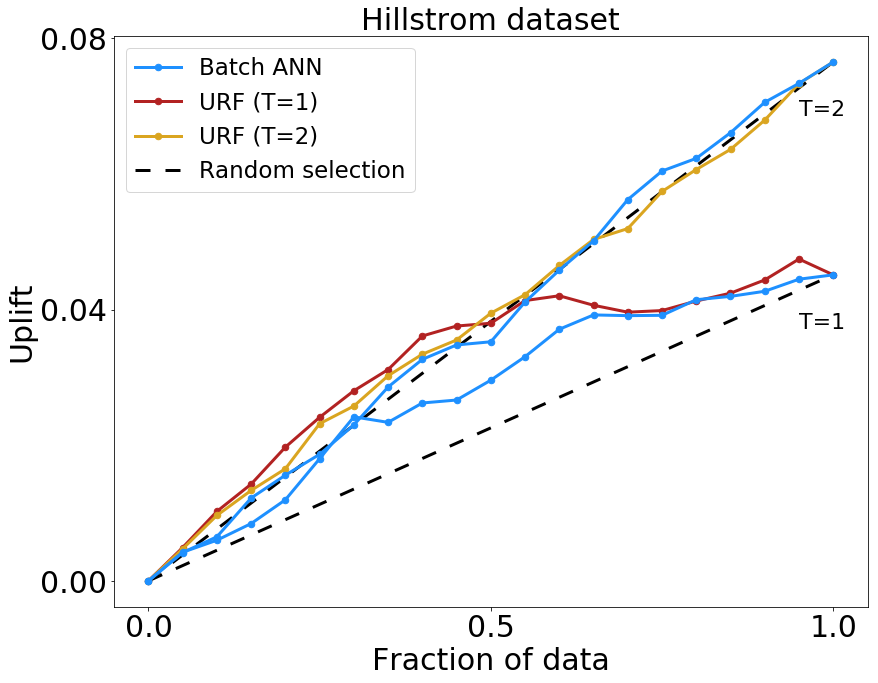

In [7]:
ax1 = qini([treats_w, treats_m], [resps_w, resps_m], [nets_w, nets_m], [forests_w, forests_m], 
               urf_label=['URF (T=1)', 'URF (T=2)'], 
               urf_colors=['firebrick', 'goldenrod'], 
               urf_colors_bands=['deeppink', 'orange'],
               treatment_names=['T=1', "T=2"],
               yticks=[0, .04, .08])